In [3]:
from ema_workbench import (RealParameter, IntegerParameter, CategoricalParameter, 
                           ScalarOutcome, Constant,
                           Model, ema_logging, perform_experiments)

#from dps_lake_model import lake_model
from model import gr_system

import os
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [25]:
domain = "sokoban"

ema_logging.LOG_FORMAT = '[%(name)s/%(levelname)s/%(processName)s] %(message)s'
ema_logging.log_to_stderr(ema_logging.INFO)
    
model = Model('grsystem', function=gr_system)

# set levers
model.uncertainties = [IntegerParameter("phi", 0,100),
                RealParameter("delta", 0, 2),
                RealParameter("lamb", 1, 2)]

# model.levers = [CategoricalParameter("domain", ["sokoban", "blocks-world"])]
model.constants = [Constant("domain", domain)]

#specify outcomes
model.outcomes = [ScalarOutcome('p_10'),
                  ScalarOutcome('r_10'),
                  ScalarOutcome('a_10'),
                  ScalarOutcome('p_30'),
                  ScalarOutcome('r_30'),
                  ScalarOutcome('a_30'),
                  ScalarOutcome('p_50'),
                  ScalarOutcome('r_50'),
                  ScalarOutcome('a_50'),
                  ScalarOutcome('p_70'),
                  ScalarOutcome('r_70'),
                  ScalarOutcome('a_70'),
                  ScalarOutcome('p_100'),
                  ScalarOutcome('r_100'),
                  ScalarOutcome('a_100'),
                  ScalarOutcome('p_avg'),
                  ScalarOutcome('r_avg'),
                  ScalarOutcome('a_avg')]


In [32]:
results = perform_experiments(model, 1000)
'''
from ema_workbench import (MultiprocessingEvaluator, ema_logging,
                           perform_experiments)
ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(model, n_processes=7) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=10)
'''

from ema_workbench import save_results
save_results(results, '1000_scenarios_%s.tar.gz'%domain)

[EMA.ema_workbench.em_framework.evaluators/INFO/MainProcess] performing 10 scenarios * 1 policies * 1 model(s) = 10 experiments
[EMA.ema_workbench.em_framework.evaluators/INFO/MainProcess] performing experiments sequentially
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 1 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 2 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 3 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 4 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 5 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 6 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 7 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 8 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 9 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 10 cases comp

NameError: name 'domain' is not defined

In [6]:
#from ema_workbench import load_results
#results = load_results('100_scenarios_blocks_world.tar.gz')

[EMA.ema_workbench.util.utilities/INFO/MainProcess] results saved successfully to /Users/zihangs/eclipse-workspace/GR_system/100_scenarios_sokoban.tar.gz


In [8]:
from SALib.analyze import sobol
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench import (MultiprocessingEvaluator, ema_logging,
                           perform_experiments)

ema_logging.log_to_stderr(ema_logging.INFO)


sa_results = perform_experiments(model, scenarios=1050, uncertainty_sampling='sobol')

experiments, outcomes = sa_results
save_results(results, '1050_scenarios_%s_sobol.tar.gz'%domain)

[EMA.ema_workbench.em_framework.evaluators/INFO/MainProcess] performing 320 scenarios * 1 policies * 1 model(s) = 320 experiments
[EMA.ema_workbench.em_framework.evaluators/INFO/MainProcess] performing experiments sequentially
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 32 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 64 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 96 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 128 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 160 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 192 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 224 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 256 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProcess] 288 cases completed
[EMA.ema_workbench.em_framework.callbacks/INFO/MainProce

### ANALYSIS DATA

The experimental results are saved in to tar.gz, to do following analysis, we need to reload the data.

[EMA.ema_workbench.analysis.feature_scoring/INFO/MainProcess] policy dropped from analysis because only a single category
[EMA.ema_workbench.analysis.feature_scoring/INFO/MainProcess] model dropped from analysis because only a single category
[EMA.ema_workbench.analysis.feature_scoring/INFO/MainProcess] policy dropped from analysis because only a single category
[EMA.ema_workbench.analysis.feature_scoring/INFO/MainProcess] model dropped from analysis because only a single category
[EMA.ema_workbench.analysis.feature_scoring/INFO/MainProcess] policy dropped from analysis because only a single category
[EMA.ema_workbench.analysis.feature_scoring/INFO/MainProcess] model dropped from analysis because only a single category
[EMA.ema_workbench.analysis.feature_scoring/INFO/MainProcess] policy dropped from analysis because only a single category
[EMA.ema_workbench.analysis.feature_scoring/INFO/MainProcess] model dropped from analysis because only a single category
[EMA.ema_workbench.analysis.

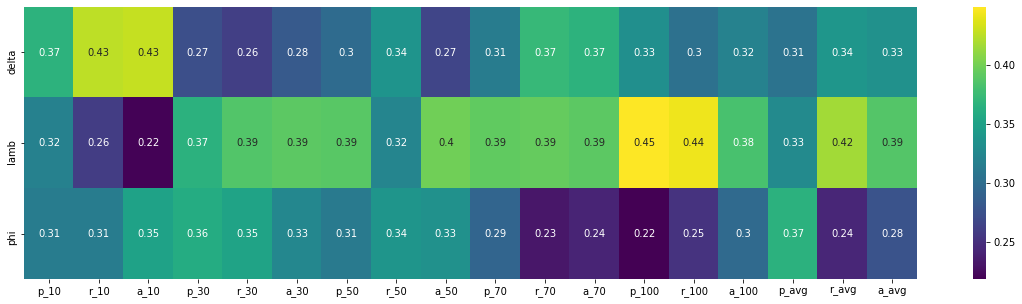

In [27]:
from ema_workbench.analysis import feature_scoring
experiments, outcomes = results
x = experiments
y = outcomes

fs = feature_scoring.get_feature_scores_all(x, y)
plt.figure(figsize = (20,5))
sns.heatmap(fs, cmap='viridis', annot=True)
plt.show()

[EMA.ema_workbench.analysis.plotting_util/INFO/MainProcess] no time dimension found in results


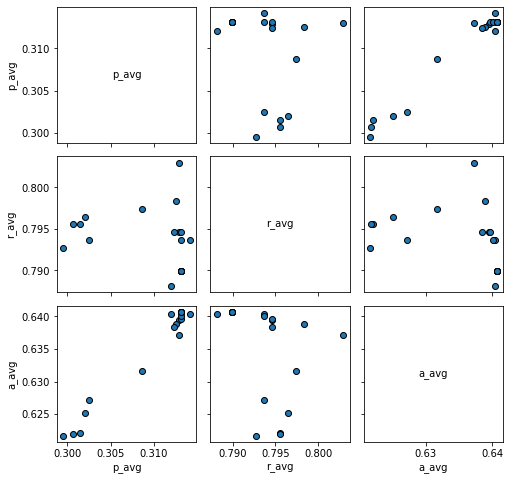

In [23]:
from ema_workbench.analysis import pairs_plotting

# partial dict
partial_outcomes = dict((key,value) for key, value in outcomes.items() if key in ["p_avg", "r_avg", "a_avg"])

fig, axes = pairs_plotting.pairs_scatter(experiments, partial_outcomes, group_by='policy',
                                         legend=False)
fig.set_size_inches(8,8)
plt.show()

### Prim algo

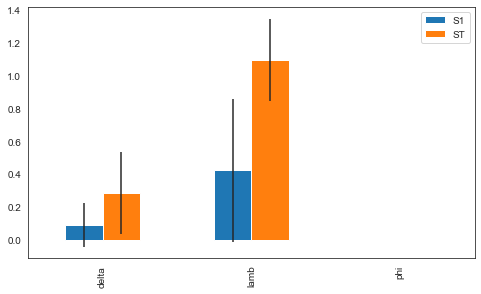

In [9]:
problem = get_SALib_problem(model.uncertainties)
Si = sobol.analyze(problem, outcomes['accuracy'],
                   calc_second_order=True, print_to_console=False)

scores_filtered = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(scores_filtered, index=problem['names'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()